*******************************************
# Triggering of Stream Data
*******************************************

In this tutorial, we trigger stream data from the continuous data aquisition.

In [1]:
import cait as ai
%config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots#

## Generate Test Data

We start again with constructing mock data, that matches the data format of the files from the continuous data acquisition. This is again done with the TestData class.

In [2]:
test_data = ai.data.TestData(filepath='test_data/mock_001', duration=1800)

We create CSMPL files of the two channels from our detector. These files contain the sample values as 16 bits integers, without header. To test the files, we plot the window of the first event.

Csmpl Files for all Channels written.
Get 15000 samples from sample 139998.0.
Create time array from 2.7999600000000004 to 3.3999200000000003 seconds.
Plot.


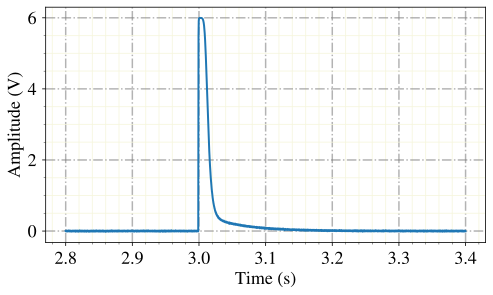

Get 15000 samples from sample 139998.0.
Create time array from 2.7999600000000004 to 3.3999200000000003 seconds.
Plot.


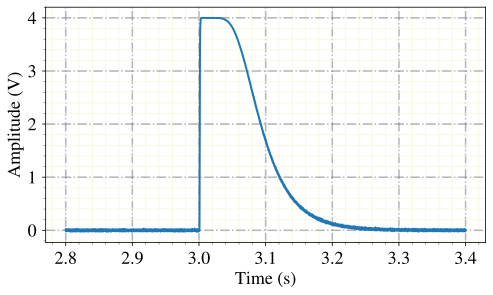

In [3]:
test_data._generate_csmpl_files()
ai.trigger.plot_csmpl(path='test_data/mock_001_Ch0.csmpl', start_time=2.8, end_time=3.4, dpi=150)
ai.trigger.plot_csmpl(path='test_data/mock_001_Ch1.csmpl', start_time=2.8, end_time=3.4, dpi=150)

The continuous data acquisition writes the start time of the CSMPL files to an SQL database. The time stamp is only saved in the precision of seconds, so the absolute time of a single events might not exactly match its true time of occurence. This is not a problem for our analysis, as we need the absolut time stamp only to chain together multiple measured files, that are each consistent in their time stamps relative to their start time.

We generate such an SQL file. To test its content, we propose to use one of many publicly availabe SQL database interfaces, e.g. https://sqlitebrowser.org/.

In [4]:
test_data._generate_sql_file()

Sql file written.


The time stamps and test pulse amplitudes of injected test pulses is written in the TEST_STAMPS file. We can match these with the triggers in the stream.

In [6]:
test_data._generate_test_stamps()
dh = ai.DataHandler(nmbr_channels=2)
dh.checkout_test(path_test='test_data/mock_001.test_stamps', read_events=5)

Test_stamps file written.
DataHandler Instance created.
stamp, tpa, tpch
(18000000, 20., 0)
(48000000, 0.1, 0)
(78000000, -1., 0)
(108000000, 20., 0)
(138000000, 0.3, 0)


The continuous data aquisition works alternatingly on two banks. This is because one bank can only record a given number of samples and then has to store it. So the two banks switch between listening and writing back and forth. The 10 MHz time stamps, starting with the start of the file, of the bank switches are written in the DIG file. There is however the complicating fact, that the 10 MHz clock does not start exactly with 0 at the start of writing the first sample, but with some offset. This offset is also present in the time stamps of the test pulses and has to be corrected. For this we need the time stamp of the bank switches, from them we can determine the offset and add it to the time stamps of the test pulses, which brings them to their true position in the stream.

In [7]:
test_data._generate_dig_stamps()
dh = ai.DataHandler(nmbr_channels=2)
dh.checkout_dig(path_dig='test_data/mock_001.dig_stamps', read_events=5)

Dig_stamps file written.
DataHandler Instance created.
stamp, bank, _
(404204800, 0, 0)
(820409600, 0, 0)
(1236614400, 0, 0)
(1652819200, 0, 0)
(2069024000, 0, 0)


We generated now all the data we need and can start with the triggering.

## Trigger

For triggering we use the optimum filter on downsampled events. Moderate downsampling does not dimish the trigger efficiency. So we first get the optimum filter transfer function that we generated in a previous notebook from the hardware data.

In [8]:
dh_hw = ai.DataHandler(nmbr_channels=2)
dh_hw.set_filepath(path_h5='test_data/', fname='test_001', appendix=False)

of_r = dh_hw.get(group='optimumfilter', dataset='optimumfilter_real_down16')
of_i = dh_hw.get(group='optimumfilter', dataset='optimumfilter_imag_down16')
of = of_r + 1j*of_i

DataHandler Instance created.


Stream triggering is done with the DataHandler class as well. So we first create a new instance and define a new file name for the data.

In [10]:
dh_stream = ai.DataHandler(nmbr_channels=2)
dh_stream.set_filepath(path_h5='test_data/', fname='stream_001', appendix=False)

DataHandler Instance created.


Now we do the actual triggering. The trigger time stamps are then writtin in the new HDF5 dataset. We need to define some file paths for the channels, thresholds, downsampling factor and with the downsampling consistent optimum filter transfer function. The downsampling speeds up the triggering significantly and eliminates the cost of triggering as time constrait in every regard. Usually we trigger both channels of the detector module, but implement a trigger block, such that a channel cannot trigger for the time of a record window after a trigger in its corresponding channel.

In [11]:
dh_stream.include_csmpl_triggers(csmpl_paths=['test_data/mock_001_Ch0.csmpl', 'test_data/mock_001_Ch1.csmpl'],
                                 thresholds=[0.02, 0.02],
                                 of=of,
                                 path_sql='test_data/mock_001.db',
                                 csmpl_channels=[0,1],  # the channel numbers in the csmpl file are different from rdt
                                 sql_file_label='mock_001',
                                 down=16,
                                 )

TRIGGER CHANNEL  0
#######################################
CURRENT STREAM NMBR 0 PATH test_data/mock_001_Ch0.csmpl
TOTAL LENGTH STREAM:  45000000



#######################################
DONE WITH ALL FILES FROM THIS CALL.
Triggers:  518
TRIGGER CHANNEL  1
#######################################
CURRENT STREAM NMBR 0 PATH test_data/mock_001_Ch1.csmpl
TOTAL LENGTH STREAM:  45000000



#######################################
DONE WITH ALL FILES FROM THIS CALL.
Triggers:  476
ALIGN TRIGGERS
ADD DATASETS TO HDF5
DONE


As second action, we include the time stamps of the test pulses. For this we need the TEST_STAMPS file, as well as the DIQ_STAMPS and the SQL files, to provide a correct matching between trigger times and test- and control pulse times.

In [12]:
dh_stream.include_test_stamps(path_teststamps='test_data/mock_001.test_stamps',
                              path_dig_stamps='test_data/mock_001.dig_stamps', 
                              path_sql='test_data/mock_001.db', 
                              csmpl_channels=[0,1], 
                              sql_file_label='mock_001',
                              fix_offset=True)

Test Stamps included.


Now we add the actual triggered events to the HDF5 files. For this we first match, which trigger time stamps are max_time_diff or closer to test pulse time stamps. These are counted as test pulses, unless the TPA is above min_cpa, then they are counted as control pulses. If the TPA is below min_tpa, they are obviously not injected test pulses be actual triggered events and counted as such. Is this function is called while there are already events in the DataHandler file, the user is first asked for approval to avoid unintended overwriting of data.

In [13]:
dh_stream.include_triggered_events(csmpl_paths=['test_data/mock_001_Ch0.csmpl', 'test_data/mock_001_Ch1.csmpl'],
                                   max_time_diff=0.5, # in sec
                                   exclude_tp=True,
                                   sample_duration=0.00004,
                                   datatype='float32',
                                   min_tpa=0.001,
                                   min_cpa=10.1,
                                   down=1)

Exclude Testpulses.
Include the triggered events.
Channel  0



Channel  1



Include Testpulse Events.
Channel  0



Channel  1



Calculate Control Pulse Heights.
Channel  0



Channel  1



DONE


So lets have a look at the spectrum of the triggered events.

CALCULATE MAIN PARAMETERS.


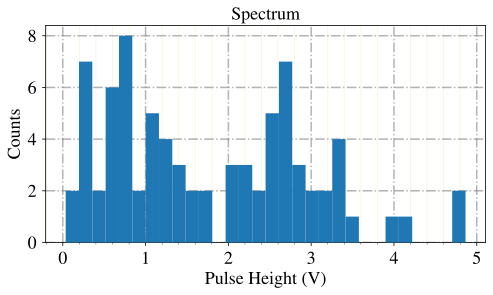

In [14]:
dh_stream.calc_mp(type='events')

channel=0

dh_stream.show_values(group='events', key='mainpar', bins=30, idx0=channel, idx2=0,
               xlabel='Pulse Height (V)', ylabel='Counts', title='Spectrum')

This look about the way we expected, with something like a calibration peak between 2.5 and 3 V and an excess as low energies.

We can now include several calculated quantities from the hardware data file to the stream file, that we might need at some point for feature calculations.

In [15]:
dh_stream.include_sev(sev=dh_hw.get('stdevent','event'), 
                      fitpar=dh_hw.get('stdevent','fitpar'), 
                      mainpar=dh_hw.get('stdevent','mainpar'))

dh_stream.include_nps(nps=dh_hw.get('noise','nps'))

dh_stream.include_of(of_real=dh_hw.get('optimumfilter','optimumfilter_real'), 
                     of_imag=dh_hw.get('optimumfilter','optimumfilter_imag'))

dh_stream.include_of(of_real=dh_hw.get('optimumfilter','optimumfilter_real_down16'), 
                     of_imag=dh_hw.get('optimumfilter','optimumfilter_imag_down16'), 
                     down=16)

SEV written.
NPS written.
OF written.
OF written.


To check for consistency of the triggered data, we can also plot the trigger rate ...

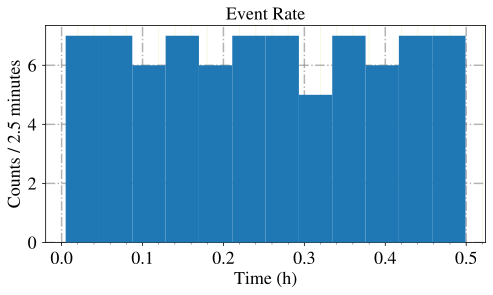

In [16]:
dh_stream.show_values(group='events', key='hours', bins=12, 
               xlabel='Time (h)', ylabel='Counts / 2.5 minutes', title='Event Rate')

... the stability of control pulses ...

(Well, the Control pulses have in our mock data all the same height, due to a poor augmentation of the detector saturation.)

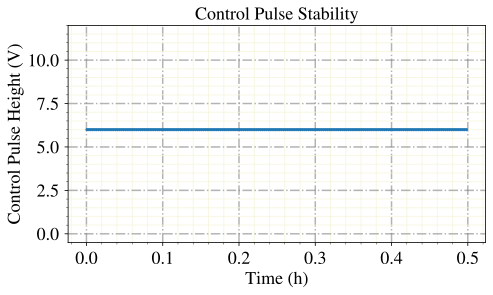

In [17]:
dh_stream.show_scatter(groups=['controlpulses', 'controlpulses'],
                        keys=['hours', 'pulse_height'],
                        idx0s=[None, 0],
                        xlabel='Time (h)',
                        ylabel='Control Pulse Height (V)',
                        yran=(-0.5, 12),
                        title='Control Pulse Stability'
                        )

... and the stability of test pulses.

CALCULATE MAIN PARAMETERS.


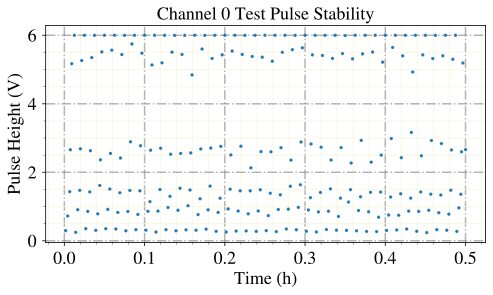

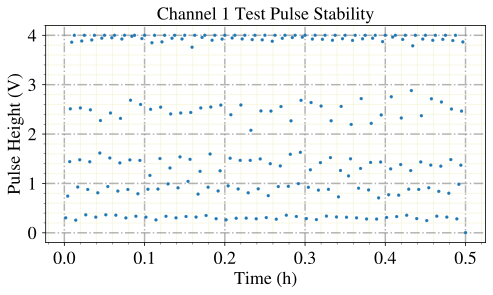

In [18]:
dh_stream.calc_mp(type='testpulses')

for c in [0,1]:
    dh_stream.show_scatter(groups=['testpulses', 'testpulses'],
                    keys=['hours', 'mainpar'],
                    idx0s=[None, c],
                    idx2s=[None, 0],
                    xlabel='Time (h)',
                    ylabel='Pulse Height (V)',
                    marker='.',
                    title='Channel {} Test Pulse Stability'.format(c)
                    )

The plots we see are consistent with the rate and stability plots that we will watch in the following notebook for the RDT events. However, notice that the events are randomized, so the RDT file does not contain exactly the same events as the CSMPL file, but some with the same properties. To generate RDT and CSMPL mock data that contain exactly the same events, you would need to generate the data with the same instance of TestData.

The HDF5 file with the stream data has now internally exactly the same structure as those that are converted from RDT files. So we can use them for the analysis exactly the same way, we use the hardware triggered data.

### View Triggered Events

Finally, we want to have a look at the triggered events, we do that again with the EventInterface. We can see one difference between the triggered and the hardware recorded data: In the triggered stream event data, the maximum position is exactly at 1/4 of the record window, while in the hardware data the trigger position within the rise of the pulse is positioned to 1/4. This produces only a minor difference in our mock data, in real measured data this shift of the true onset is more significant and depends also on the pulse height.

In [20]:
ei = ai.EventInterface(nmbr_channels=2)
ei.load_h5(path='test_data/', fname='stream_001', channels=[0,1], appendix=False, which_to_label=['events'])
ei.create_labels_csv(path='test_data/')

Event Interface Instance created.
Nmbr triggered events:  79
Nmbr testpulses:  240
No noise in h5 file.
HDF5 File loaded.


Start labeling from idx 0.
Labels autosave to test_data/labels_stream_001_.


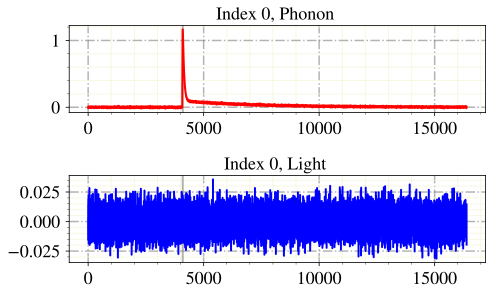

Label Phonon: 0.0
Label Light: 0.0
Assign label for event idx: 0 Phonon (q end, b back, n next, o options, i idx, p for (de)activate label list)

Phonon: n
Skipping this label.


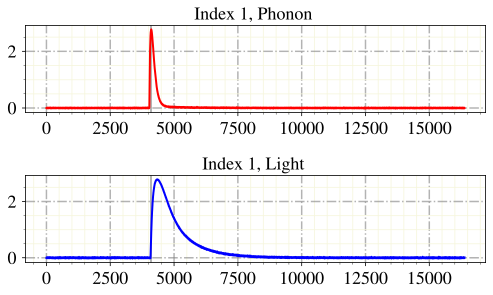

Label Phonon: 0.0
Label Light: 0.0
Assign label for event idx: 1 Phonon (q end, b back, n next, o options, i idx, p for (de)activate label list)

Phonon: n
Skipping this label.


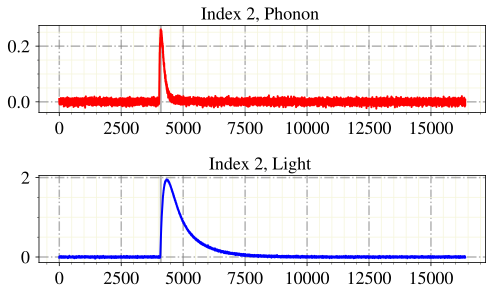

Label Phonon: 0.0
Label Light: 0.0
Assign label for event idx: 2 Phonon (q end, b back, n next, o options, i idx, p for (de)activate label list)

Phonon: q
End labeling.


In [21]:
ei.start(start_from_idx=0, print_label_list=False)

Also for stream data, we can merge multiple files, drop events and include them again.

In [22]:
test_data.update_filepath(file_path='test_data/mock_002')
test_data.generate(start_offset=1.5 * 3600, source='stream')

Csmpl Files for all Channels written.
Sql file written.
Dig_stamps file written.
Test_stamps file written.


In [25]:
dh_stream = ai.DataHandler(nmbr_channels=2)
dh_stream.set_filepath(path_h5='test_data/', fname='stream_002', appendix=False)


dh_stream.include_csmpl_triggers(csmpl_paths=['test_data/mock_002_Ch0.csmpl', 'test_data/mock_002_Ch1.csmpl'],
                                 thresholds=[0.02, 0.02],
                                 of=of,
                                 path_sql='test_data/mock_002.db',
                                 csmpl_channels=[0,1],  # the channel numbers in the csmpl file are different from rdt
                                 sql_file_label='mock_002',
                                 down=16,
                                 )    
    
dh_stream.include_test_stamps(path_teststamps='test_data/mock_002.test_stamps',
                              path_dig_stamps='test_data/mock_002.dig_stamps', 
                              path_sql='test_data/mock_002.db', 
                              csmpl_channels=[0,1], 
                              sql_file_label='mock_002',
                              fix_offset=True)

dh_stream.include_triggered_events(csmpl_paths=['test_data/mock_002_Ch0.csmpl', 'test_data/mock_002_Ch1.csmpl'],
                                   max_time_diff=0.5, # in sec
                                   exclude_tp=True,
                                   sample_duration=0.00004,
                                   datatype='float32',
                                   min_tpa=0.001,
                                   min_cpa=10.1,
                                   down=1)

DataHandler Instance created.
TRIGGER CHANNEL  0
#######################################
CURRENT STREAM NMBR 0 PATH test_data/mock_002_Ch0.csmpl
TOTAL LENGTH STREAM:  45000000



#######################################
DONE WITH ALL FILES FROM THIS CALL.
Triggers:  518
TRIGGER CHANNEL  1
#######################################
CURRENT STREAM NMBR 0 PATH test_data/mock_002_Ch1.csmpl
TOTAL LENGTH STREAM:  45000000



#######################################
DONE WITH ALL FILES FROM THIS CALL.
Triggers:  476
ALIGN TRIGGERS
ADD DATASETS TO HDF5
DONE
Test Stamps included.
Exclude Testpulses.
Include the triggered events.
Channel  0



Channel  1



Include Testpulse Events.
Channel  0



Channel  1



Calculate Control Pulse Heights.
Channel  0



Channel  1



DONE


In [27]:
ai.data.merge_h5_sets(path_h5_a='test_data/' + 'stream_001.h5', 
                      path_h5_b='test_data/' + 'stream_002.h5', 
                      path_h5_merged='test_data/' + 'stream_merged_001.h5', 
                      continue_hours=True,
                      keep_original_files=True,
                      a_name='stream_001',
                      b_name='stream_002',
                     )

Merge done.


In [29]:
dh_stream = ai.DataHandler(nmbr_channels=2)
dh_stream.set_filepath(path_h5='test_data/', fname='stream_merged_001', appendix=False)

DataHandler Instance created.


In [30]:
dh_stream.drop_raw_data()

Dataset Event deleted from group events.


In [31]:
for fname in ['mock_001', 'mock_002']:
    dh_stream.include_triggered_events(csmpl_paths=['test_data/' + fname + '_Ch0.csmpl', 'test_data/' + fname + '_Ch1.csmpl'],
                                       max_time_diff=0.5, # in sec
                                       exclude_tp=True,
                                       sample_duration=0.00004,
                                       datatype='float32',
                                       min_tpa=0.001,
                                       min_cpa=10.1,
                                       down=1)

An events group exists in this file. Overwriting with a different number of events, e.g.after retriggering, might lead to issues in feature calculations. Overwrite anyway? y/ny
Exclude Testpulses.
Include the triggered events.
Channel  0



Channel  1



Include Testpulse Events.
Channel  0



Channel  1



Calculate Control Pulse Heights.
Channel  0



Channel  1



DONE
An events group exists in this file. Overwriting with a different number of events, e.g.after retriggering, might lead to issues in feature calculations. Overwrite anyway? y/ny
Exclude Testpulses.
Include the triggered events.
Channel  0



Channel  1



Include Testpulse Events.
Channel  0



Channel  1



Calculate Control Pulse Heights.
Channel  0



Channel  1



DONE


Please forward questions and correspondence about this notebook to felix.wagner(at)oeaw.ac.at.